<a href="https://colab.research.google.com/github/PriyaBansal68/ML-Project-winter-2022/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import gc
import numpy as np
import pandas as pd
import datetime as dt
#
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
#
import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers
# from tensorflow.keras.layers import Bidirectional, LSTM, MaxPooling2D, Conv2D
# from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Masking
# from tensorflow.keras.layers import Concatenate, Add, GRU
# from tensorflow.keras.callbacks import ModelCheckpoint

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Football/train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
for col in df.filter(regex='date', axis=1).columns:
    df[col] = pd.to_datetime(df[col])

# Some feature engineering
def add_features(df):
    for i in range(1, 11): # range from 1 to 10
        # Feat. difference of days
        df[f'home_team_history_match_DIFF_day_{i}'] = (df['match_date'] - df[f'home_team_history_match_date_{i}']).dt.days
        df[f'away_team_history_match_DIFF_days_{i}'] = (df['match_date'] - df[f'away_team_history_match_date_{i}']).dt.days
    # Feat. difference of scored goals
        df[f'home_team_history_DIFF_goal_{i}'] = df[f'home_team_history_goal_{i}'] - df[f'home_team_history_opponent_goal_{i}']
        df[f'away_team_history_DIFF_goal_{i}'] = df[f'away_team_history_goal_{i}'] - df[f'away_team_history_opponent_goal_{i}']
    # Results: multiple nested where # away:0, draw:1, home:2
        df[f'home_team_result_{i}'] = np.where(df[f'home_team_history_DIFF_goal_{i}'] > 0, 2,
                         (np.where(df[f'home_team_history_DIFF_goal_{i}'] == 0, 1,
                                   np.where(df[f'home_team_history_DIFF_goal_{i}'].isna(), np.nan, 0))))
        df[f'away_team_result_{i}'] = np.where(df[f'away_team_history_DIFF_goal_{i}'] > 0, 2,
                         (np.where(df[f'away_team_history_DIFF_goal_{i}'] == 0, 1,
                                   np.where(df[f'away_team_history_DIFF_goal_{i}'].isna(), np.nan, 0))))
    # Feat. difference of rating ("modified" ELO RATING)
        df[f'home_team_history_ELO_rating_{i}'] = 1/(1+10**((df[f'home_team_history_opponent_rating_{i}']-df[f'home_team_history_rating_{i}'])/10))
        df[f'away_team_history_ELO_rating_{i}'] = 1/(1+10**((df[f'away_team_history_opponent_rating_{i}']-df[f'away_team_history_rating_{i}'])/10))
        df[f'home_away_team_history_ELO_rating_{i}'] = 1/(1+10**((df[f'away_team_history_rating_{i}']-df[f'home_team_history_rating_{i}'])/10))
        # df[f'away_team_history_DIFF_rating_{i}'] =  - df[f'away_team_history_opponent_rating_{i}']
    # Feat. same coach id
        df[f'home_team_history_SAME_coaX_{i}'] = np.where(df['home_team_coach_id']==df[f'home_team_history_coach_{i}'],1,0)
        df[f'away_team_history_SAME_coaX_{i}'] = np.where(df['away_team_coach_id']==df[f'away_team_history_coach_{i}'],1,0) 
    # Feat. same league id
        df[f'home_team_history_SAME_leaG_{i}'] = np.where(df['league_id']==df[f'home_team_history_league_id_{i}'],1,0)
        df[f'away_team_history_SAME_leaG_{i}'] = np.where(df['league_id']==df[f'away_team_history_league_id_{i}'],1,0) 
    # Fill NA with -666
    # df.fillna(MASK, inplace = True)
    return df

train = add_features(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, us

In [4]:
train_y = df['target'].copy()
#keep only some features
train_x = df.drop(['target', 'home_team_name', 'away_team_name'], axis=1) #, inplace=True) # is_cup EXCLUDED
# Exclude all date, league, coach columns
train_x.drop(train.filter(regex='date').columns, axis=1, inplace = True)
train_x.drop(train.filter(regex='league').columns, axis=1, inplace = True)
train_x.drop(train.filter(regex='coach').columns, axis=1, inplace = True)

In [5]:
print(f"Target: {train_y.shape} \n Train shape: {train_x.shape}")
print(f"Column names: {list(train_x.columns)}")

Target: (110938,) 
 Train shape: (110938, 252)
Column names: ['id', 'is_cup', 'home_team_history_is_play_home_1', 'home_team_history_is_play_home_2', 'home_team_history_is_play_home_3', 'home_team_history_is_play_home_4', 'home_team_history_is_play_home_5', 'home_team_history_is_play_home_6', 'home_team_history_is_play_home_7', 'home_team_history_is_play_home_8', 'home_team_history_is_play_home_9', 'home_team_history_is_play_home_10', 'home_team_history_is_cup_1', 'home_team_history_is_cup_2', 'home_team_history_is_cup_3', 'home_team_history_is_cup_4', 'home_team_history_is_cup_5', 'home_team_history_is_cup_6', 'home_team_history_is_cup_7', 'home_team_history_is_cup_8', 'home_team_history_is_cup_9', 'home_team_history_is_cup_10', 'home_team_history_goal_1', 'home_team_history_goal_2', 'home_team_history_goal_3', 'home_team_history_goal_4', 'home_team_history_goal_5', 'home_team_history_goal_6', 'home_team_history_goal_7', 'home_team_history_goal_8', 'home_team_history_goal_9', 'home_te

In [6]:
train_x.head()

,id,is_cup,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,...,away_team_history_DIFF_goal_10,home_team_result_10,away_team_result_10,home_team_history_ELO_rating_10,away_team_history_ELO_rating_10,home_away_team_history_ELO_rating_10,home_team_history_SAME_coaX_10,away_team_history_SAME_coaX_10,home_team_history_SAME_leaG_10,away_team_history_SAME_leaG_10
0,11906497,False,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,2.0,2.0,2.0,0.698653,0.570885,0.567616,1,1,1,0
1,11984383,False,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,3.0,1.0,2.0,0.711318,0.204827,0.718473,1,1,1,1
2,11983301,False,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.587305,0.805052,0.281921,1,1,1,1
3,11983471,False,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,-1.0,1.0,0.0,0.691667,0.368863,0.642603,1,1,1,1
4,11883005,False,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.801097,0.347241,0.785462,1,0,1,1


In [7]:
feature_groups = ["home_team_history_is_play_home", "home_team_history_is_cup",
    "home_team_history_goal", "home_team_history_opponent_goal",
    "home_team_history_rating", "home_team_history_opponent_rating",  
    "away_team_history_is_play_home", "away_team_history_is_cup",
    "away_team_history_goal", "away_team_history_opponent_goal",
    "away_team_history_rating", "away_team_history_opponent_rating",  
    "home_team_history_match_DIFF_day", "away_team_history_match_DIFF_days",
    "home_team_history_DIFF_goal","away_team_history_DIFF_goal",
    "home_team_history_ELO_rating","away_team_history_ELO_rating",
    "home_away_team_history_ELO_rating",
    "home_team_history_SAME_coaX", "away_team_history_SAME_coaX",
    "home_team_history_SAME_leaG", "away_team_history_SAME_leaG",
    "home_team_result", "away_team_result"]      
# Pivot dimension (id*features) x time_history
train_x_pivot = pd.wide_to_long(train_x, stubnames=feature_groups, 
                i=['id','is_cup'], j='time', sep='_', suffix='\d+')
#
print(f"Train pivot shape: {train_x_pivot.shape}")  


Train pivot shape: (1109380, 25)


In [8]:
# create columns based on index
train_x_pivot = train_x_pivot.reset_index()

# Deal with the is_cup feature
# There are na in 'is_cup'
train_x_pivot=train_x_pivot.fillna({'is_cup':False})
train_x_pivot['is_cup'] = pd.get_dummies(train_x_pivot['is_cup'], drop_first=True)


In [9]:
train_x_pivot.head(20)

,id,is_cup,time,home_team_history_is_play_home,home_team_history_is_cup,home_team_history_goal,home_team_history_opponent_goal,home_team_history_rating,home_team_history_opponent_rating,away_team_history_is_play_home,...,away_team_history_DIFF_goal,home_team_history_ELO_rating,away_team_history_ELO_rating,home_away_team_history_ELO_rating,home_team_history_SAME_coaX,away_team_history_SAME_coaX,home_team_history_SAME_leaG,away_team_history_SAME_leaG,home_team_result,away_team_result
0,11906497,0,1,0.0,0.0,0.0,1.0,3.856860,5.199840,0.0,...,-1.0,0.423302,0.462354,0.457440,1,1,1,0,0.0,0.0
1,11906497,0,2,1.0,0.0,2.0,0.0,5.724370,3.694033,1.0,...,2.0,0.614792,0.888312,0.197047,1,1,1,0,2.0,2.0
2,11906497,0,3,0.0,0.0,0.0,1.0,4.335091,5.131156,1.0,...,-1.0,0.454303,0.808676,0.238585,1,1,1,1,0.0,0.0
3,11906497,0,4,1.0,0.0,0.0,4.0,6.678853,3.193161,0.0,...,1.0,0.690533,0.758992,0.409659,1,1,1,1,0.0,2.0
4,11906497,0,5,0.0,0.0,3.0,1.0,5.478300,4.080169,1.0,...,1.0,0.579795,0.868420,0.228225,1,1,1,1,2.0,2.0
5,11906497,0,6,1.0,0.0,0.0,0.0,5.858534,3.898775,0.0,...,-1.0,0.610937,0.430964,0.567409,1,1,1,0,1.0,0.0
6,11906497,0,7,0.0,0.0,1.0,1.0,3.641945,7.672377,0.0,...,0.0,0.283322,0.605444,0.344807,1,1,1,1,1.0,1.0
7,11906497,0,8,1.0,0.0,2.0,0.0,7.957243,2.864026,1.0,...,2.0,0.763643,0.907745,0.248081,1,1,1,0,2.0,2.0
8,11906497,0,9,0.0,0.0,1.0,1.0,4.326252,4.814193,1.0,...,2.0,0.471941,0.860812,0.177999,1,1,1,1,1.0,2.0
9,11906497,0,10,1.0,0.0,4.0,1.0,7.106259,3.454310,1.0,...,2.0,0.698653,0.570885,0.567616,1,1,1,0,2.0,2.0


In [11]:
x_train = train_x_pivot.drop(['id', 'time'], axis=1)

# Scale features using statistics that are robust to outliers
RS = RobustScaler()
x_train = RS.fit_transform(x_train)

# Fill NA with MASK
x_train = np.nan_to_num(x_train, nan=-666)

# Reshape 
x_train = x_train.reshape(-1, 10, x_train.shape[-1])


In [12]:
print(f"Train array shape: {x_train.shape}")

Train array shape: (110938, 10, 26)


In [13]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_y)
encoded_y = encoder.transform(train_y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_y)
# 
print(encoded_y.shape)
print(dummy_y.shape)

(110938,)
(110938, 3)


In [14]:
# encoding away: 0 draw: 1 home: 2 
print(encoded_y[:10,])
# Order: away, draw, home
print(dummy_y[:10,])

[0 2 1 0 2 1 2 0 2 2]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [24]:
def model_2():
    x_input = layers.Input(shape=x_train.shape[1:])
    x = layers.Masking(mask_value=-666, input_shape=(x_train.shape[1:]))(x_input)
    x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(x)
    x = layers.Dropout(0.5)(x)  
    x = layers.Bidirectional(layers.LSTM(8, return_sequences=True))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    # output
    output = layers.Dense(3, activation='softmax')(x)
    model = Model(inputs=[x_input],outputs=[output])

    return model

In [25]:
model = model_2()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 26)]          0         
                                                                 
 masking (Masking)           (None, 10, 26)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 10, 32)           5504      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 16)           2624      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 16)            0     

In [33]:
EPOCH = 150
BATCH_SIZE = 512
N_SPLITS = 5
SEED = 123
VERBOSE = 1
PATIENCE = EPOCH // 10
VAL_SPLIT = 0.2
# Model
# It is a multi-class classification problem, categorical_crossentropy is used as the loss function.
model.compile(optimizer="adam", loss="categorical_crossentropy",
                 metrics=["accuracy"])
#
es = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=0, mode='min',restore_best_weights=True)
scheduler = ExponentialDecay(3e-3, 40*((len(x_train))/BATCH_SIZE), 1e-4)
lr = LearningRateScheduler(scheduler, verbose = 0)
#
h=model.fit(x_train, dummy_y, 
              # validation_data=(x_train, y_train), 
              validation_split=VAL_SPLIT,
              epochs=EPOCH,
              verbose=VERBOSE,
              batch_size=BATCH_SIZE,
              callbacks=[lr, es])

Epoch 1/150
174/174 [==============================] - 36s 117ms/step - loss: 1.0040 - accuracy: 0.5046 - val_loss: 1.0044 - val_accuracy: 0.5028 - lr: 0.0030
Epoch 2/150
174/174 [==============================] - 11s 61ms/step - loss: 1.0038 - accuracy: 0.5054 - val_loss: 1.0037 - val_accuracy: 0.5027 - lr: 0.0030
Epoch 3/150
174/174 [==============================] - 11s 61ms/step - loss: 1.0035 - accuracy: 0.5052 - val_loss: 1.0035 - val_accuracy: 0.5017 - lr: 0.0030
Epoch 4/150
174/174 [==============================] - 10s 60ms/step - loss: 1.0030 - accuracy: 0.5046 - val_loss: 1.0039 - val_accuracy: 0.5015 - lr: 0.0030
Epoch 5/150
174/174 [==============================] - 12s 68ms/step - loss: 1.0022 - accuracy: 0.5063 - val_loss: 1.0045 - val_accuracy: 0.5011 - lr: 0.0030
Epoch 6/150
174/174 [==============================] - 12s 69ms/step - loss: 1.0012 - accuracy: 0.5076 - val_loss: 1.0049 - val_accuracy: 0.5021 - lr: 0.0030
Epoch 7/150
174/174 [==============================

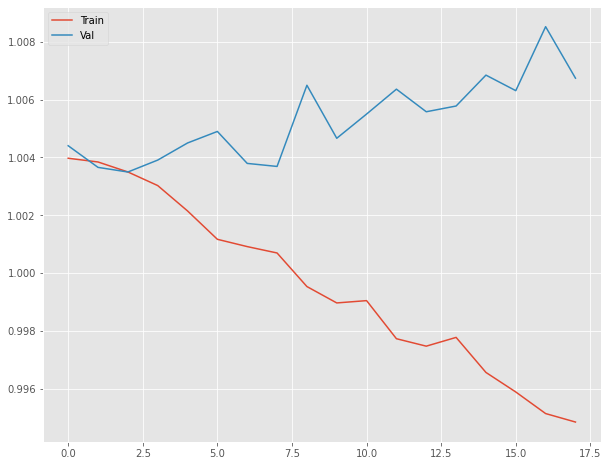

In [34]:
import matplotlib.pylab as plt
plt.plot(h.history['loss'], label='Train')
plt.plot(h.history['val_loss'], label='Val')
plt.legend();

In [38]:
EPOCH = 300
BATCH_SIZE = 512
N_SPLITS = 5
SEED = 123
VERBOSE = 1
PATIENCE = EPOCH // 10

test_preds = []

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, test_idx) in enumerate(kf.split(x_train, dummy_y)):
    print('-'*15, '>', f'Fold {fold+1}/{N_SPLITS}', '<', '-'*15)
    X_train, X_valid = x_train[train_idx], x_train[test_idx]
    Y_train, Y_valid = dummy_y[train_idx], dummy_y[test_idx]
    # Model
    model = model_2()
    # It is a multi-class classification problem, categorical_crossentropy is used as the loss function.
    model.compile(optimizer="adam", loss="categorical_crossentropy",
                 metrics=["accuracy"])
    #
    es = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=0, mode='min',
                       restore_best_weights=True)
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=0)
    #
    s=model.fit(X_train, Y_train, 
              validation_data=(X_valid, Y_valid), 
              epochs=EPOCH,
              verbose=VERBOSE,
              batch_size=BATCH_SIZE,  
              callbacks=[lr, es])
    # Model validation    
    y_true = Y_valid.squeeze()
    y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze()
    score1 = log_loss(y_true, y_pred)
    print(f"Fold-{fold+1} | OOF LogLoss Score: {score1}")
    # Predictions
    #test_preds.append(model.predict(x_test).squeeze()) 


--------------- > Fold 1/5 < ---------------
Epoch 1/300
174/174 [==============================] - 31s 88ms/step - loss: 1.0389 - accuracy: 0.4731 - val_loss: 1.0143 - val_accuracy: 0.4965 - lr: 0.0010
Epoch 2/300
174/174 [==============================] - 10s 55ms/step - loss: 1.0222 - accuracy: 0.4895 - val_loss: 1.0110 - val_accuracy: 0.5008 - lr: 0.0010
Epoch 3/300
174/174 [==============================] - 10s 55ms/step - loss: 1.0171 - accuracy: 0.4928 - val_loss: 1.0097 - val_accuracy: 0.5011 - lr: 0.0010
Epoch 4/300
174/174 [==============================] - 9s 54ms/step - loss: 1.0142 - accuracy: 0.4960 - val_loss: 1.0085 - val_accuracy: 0.5008 - lr: 0.0010
Epoch 5/300
174/174 [==============================] - 9s 54ms/step - loss: 1.0126 - accuracy: 0.4969 - val_loss: 1.0081 - val_accuracy: 0.5018 - lr: 0.0010
Epoch 6/300
174/174 [==============================] - 10s 55ms/step - loss: 1.0121 - accuracy: 0.4968 - val_loss: 1.0074 - val_accuracy: 0.5009 - lr: 0.0010
Epoch 7/3

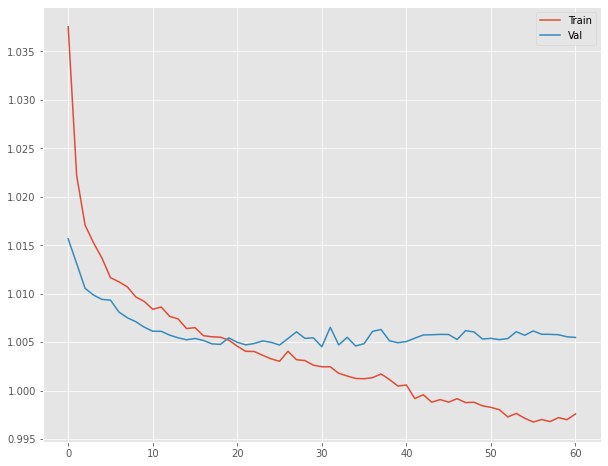

In [39]:
plt.plot(s.history['loss'], label='Train')
plt.plot(s.history['val_loss'], label='Val')
plt.legend();